In [1]:
from pandas_datareader import data as pdr
from yahoo_fin import stock_info as si
import yfinance as yf
import pandas as pd
import datetime
import time
import talib
from talib import *
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from xgboost import XGBClassifier
import xgboost as xgb
import math
import numpy as np
from sklearn.decomposition import PCA
import pickle
import os
os.environ["PATH"] += os.pathsep + r'C:\Program Files\Graphviz\bin'
yf.pdr_override()

In [2]:
from LSSVMRegression import LSSVMRegression

In [3]:
def add_indicators():
        
    R_S_I = RSI(df['Adj Close'], timeperiod=slow)
    E_M_A = EMA(df['Adj Close'], timeperiod=fast)
    macd, macdsig, macdhist = MACD(df['Adj Close'], fastperiod=fast, slowperiod=slow, signalperiod=really_fast)
    mfi = MFI(df['High'], df['Low'], df['Adj Close'],df['Volume'],timeperiod=fast)
    slowk, slowd = STOCH(df['High'], df['Low'], df['Adj Close'], fastk_period=fast, slowk_period=slow, slowk_matype=0, slowd_period=slow, slowd_matype=0)
    
    #
    #
    #
    
    df['ema'] = E_M_A
    df['rsi'] = R_S_I
    df['macd'] = macd
    df['macdsig'] = macdsig
    df['macdhist'] = macdhist
    df['mfi'] = mfi
    df['slowK'] = slowk
    df['slowD'] = slowd
    
    
    
    ####
    
    

    #76 vars

    #are_all_zero = (test_TA == 0).all()
    #true if all values are 0
    #false if contain a non 0'''

    df.drop(['Close'], axis =1, inplace = True)

    

In [4]:
def add_lag(num_lag_cols, this_df):
    
    tic = time.perf_counter()
    
    '''df['ema'] = E_M_A
    df['rsi'] = R_S_I
    df['macd'] = macd
    df['macdsig'] = macdsig
    df['macdhist'] = macdhist
    df['mfi'] = mfi
    df['slowK'] = slowk
    df['slowD'] = slowd'''
    
    lag_cols = ['open',
                 'high',
                 'low',
                 'adj_close',
                 'volume',
                 'ema',
                 'rsi',
                 'macd',
                 'macdsig',
                 'macdhist',
                 'mfi',
                 'slowk',
                 'slowd']

    shift_range = [x+1 for x in range(num_lag_cols)]

    for shift in shift_range:
        train_shift = this_df[merging_keys + lag_cols].copy()

        # E.g. order_day of 0 becomes 1, for shift = 1.
        # So when this is merged with order_day of 1 in df, this will represent lag of 1.
        train_shift['order_day'] = train_shift['order_day'] + shift

        foo = lambda x: '{}_lag_{}'.format(x, shift) if x in lag_cols else x
        train_shift = train_shift.rename(columns=foo)

        this_df = pd.merge(this_df, train_shift, on=merging_keys, how='left') #.fillna(0)

    del train_shift
    
    toc = time.perf_counter()

    tic_toc = (toc - tic) / 60

    print(f"completed lagging in {tic_toc:0.4f} min")
    

    return this_df

In [5]:
def add_scale(num_interval_lag):

    cols_to_scale = ['open',#
                     'high',#
                     'low',#
                     'adj_close',#
                     'volume',#
                     'ema',#
                     'rsi',#
                     'macd',#
                     'macdsig',#
                     'macdhist',#
                     'mfi',#
                     'slowk',#
                     'slowd']#
                    

    for i in range(1,num_interval_lag+1):
        cols_to_scale.append("ema_lag_"+str(i))
        cols_to_scale.append("slowk_lag_"+str(i))
        cols_to_scale.append("slowd_lag_"+str(i))
        cols_to_scale.append("rsi_lag_"+str(i))

        cols_to_scale.append("volume_lag_"+str(i))

        cols_to_scale.append("adj_close_lag_"+str(i))
        
        cols_to_scale.append("open_lag_"+str(i))
        cols_to_scale.append("high_lag_"+str(i))
        cols_to_scale.append("low_lag_"+str(i))

        cols_to_scale.append("macd_lag_"+str(i))
        cols_to_scale.append("macdsig_lag_"+str(i))
        cols_to_scale.append("macdhist_lag_"+str(i))

        cols_to_scale.append("mfi_lag_"+str(i))
      
    return cols_to_scale

In [32]:
stock = 'SNAP'

start_date = datetime.datetime.now() - datetime.timedelta(days=59)

end_date = datetime.datetime.now()

df = pdr.get_data_yahoo(stock, start=start_date, end=end_date, interval = "2m", prepost = True)

#df = pdr.get_data_yahoo(stock, period = "max", interval = "1d", prepost = True)

#df.index = df.index.tz_localize(None)

'''#2 min ticker
# 30 intervals = 1 hour << OLD
# 195 intervals = trading day'''
                                            # there are more intervals that we can use / change
really_fast = 30
fast = 60
slow = 90

add_indicators()

# Convert Date column to datetime
df.reset_index(level=0, inplace=True)

# Change all column headings to be lower case, and remove spacing
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]

df['order_day'] = [x for x in list(range(len(df)))]
# merging_keys


# Get difference between high and low of each day

[*********************100%***********************]  1 of 1 completed


In [33]:
col_list = df.columns.to_list()
col_list.remove('datetime')

In [34]:
col_list

['open',
 'high',
 'low',
 'adj_close',
 'volume',
 'ema',
 'rsi',
 'macd',
 'macdsig',
 'macdhist',
 'mfi',
 'slowk',
 'slowd',
 'order_day']

In [35]:
merging_keys = ['order_day']

num_interval_lag = 30

df = add_lag(num_interval_lag, df)

#df['adj_close'] = df['adj_close'].shift(30)

completed lagging in 0.0282 min


In [36]:
print(df.shape)

(12979, 405)


In [37]:
print(df.head(40))

                    datetime     open     high    low  adj_close  volume  ema  \
0  2021-01-13 19:00:00-05:00  53.5000  53.6500  53.50    53.6000       0  NaN   
1  2021-01-13 19:02:00-05:00  53.2500  53.4300  53.08    53.4300       0  NaN   
2  2021-01-13 19:04:00-05:00  53.2500  53.2500  53.25    53.2500       0  NaN   
3  2021-01-13 19:06:00-05:00  53.6000  53.6000  53.23    53.6000       0  NaN   
4  2021-01-13 19:08:00-05:00  53.6000  53.6000  53.23    53.6000       0  NaN   
5  2021-01-13 19:10:00-05:00  53.6000  53.8000  53.50    53.8000       0  NaN   
6  2021-01-13 19:12:00-05:00  53.4400  53.4500  53.30    53.4300       0  NaN   
7  2021-01-13 19:14:00-05:00  53.7000  53.7000  53.70    53.7000       0  NaN   
8  2021-01-13 19:16:00-05:00  53.6200  53.7000  53.43    53.4400       0  NaN   
9  2021-01-13 19:18:00-05:00  53.5000  53.5000  53.43    53.4400       0  NaN   
10 2021-01-13 19:20:00-05:00  53.5100  53.7000  53.51    53.7000       0  NaN   
11 2021-01-13 19:22:00-05:00

In [38]:
window_size = 30

df['adj_close'] = df['adj_close'].shift(-window_size)



In [39]:
cols_to_rem = ['open',
                 'high',
                 'low',
                 'volume',
                 'ema',
                 'rsi',
                 'macd',
                 'macdsig',
                 'macdhist',
                 'mfi',
                 'slowk',
                 'slowd',
                 'order_day']

In [40]:
close_vals_list = df['adj_close']

In [41]:
df.drop(cols_to_rem, axis = 1, inplace = True)

In [42]:
print(df.tail(40))

                       datetime  adj_close  open_lag_1  high_lag_1  low_lag_1  \
12939 2021-03-02 05:44:00-05:00      66.66       65.99       66.01      65.95   
12940 2021-03-02 05:46:00-05:00      66.65       66.11       66.12      66.01   
12941 2021-03-02 05:48:00-05:00      66.66       66.03       66.03      65.81   
12942 2021-03-02 05:58:00-05:00      66.57       65.95       65.95      65.95   
12943 2021-03-02 06:14:00-05:00      66.65       65.99       65.99      65.69   
12944 2021-03-02 06:16:00-05:00      66.65       65.99       66.00      65.99   
12945 2021-03-02 06:18:00-05:00      66.63       66.00       66.00      65.85   
12946 2021-03-02 06:24:00-05:00      66.56       65.88       65.99      65.88   
12947 2021-03-02 06:26:00-05:00      66.60       65.99       65.99      65.99   
12948 2021-03-02 06:28:00-05:00      66.53       65.99       65.99      65.99   
12949 2021-03-02 06:32:00-05:00        NaN       66.00       66.00      66.00   
12950 2021-03-02 06:34:00-05

In [43]:


#close_vals_list = df['adj_close']

df.fillna(0, inplace=True)

#df.fillna(0, inplace=True)

#BUY => 1, SELL => 0, HOLD => 2

num_test = int(.10*len(df))
num_train = len(df) - num_test

# Split into train, cv, and test
train = df[:num_train]
test = df[num_train:]

#print(test['datetime'].iloc[[-1]])
#print(test['test_labels'].iloc[[-1]])

train_close_vals = close_vals_list[:num_train]
test_close_vals = close_vals_list[num_train:]

#test_dates_list = test['date']
#BUY => 1, SELL => 0, HOLD => 2

In [44]:
test_dates_list = test['datetime']

In [45]:
train_dates_list = train['datetime']

In [46]:
test_adj_close_list = close_vals_list[num_train:]

In [47]:
cols_to_scale = add_scale(num_interval_lag)
#cols_to_scale.remove(cols_to_rem)

# Do scaling for train set
# Here we only scale the train dataset, and not the entire dataset to prevent information leak


In [48]:
for element in cols_to_rem:

    if element in cols_to_scale:

        cols_to_scale.remove(element)

In [49]:
from sklearn.preprocessing import StandardScaler

In [50]:
#scaler = StandardScaler()

scaler = StandardScaler()

scaler.fit(train[cols_to_scale])
train_scaled = scaler.transform(train[cols_to_scale])

# Convert the numpy array back into pandas dataframe

train_scaled = pd.DataFrame(train_scaled, columns=cols_to_scale)

train_scaled = train_scaled[slow:]
train = train[slow:]

#scaling test dataset

#scaler_2 = StandardScaler()

#scaler_2  = MinMaxScaler(feature_range=(-1,1))
#scaler.fit(test[cols_to_scale])
test_scaled = scaler.transform(test[cols_to_scale])

# Convert the numpy array back into pandas dataframe

test_scaled = pd.DataFrame(test_scaled, columns=cols_to_scale)

features = cols_to_scale

In [51]:
features

['adj_close',
 'ema_lag_1',
 'slowk_lag_1',
 'slowd_lag_1',
 'rsi_lag_1',
 'volume_lag_1',
 'adj_close_lag_1',
 'open_lag_1',
 'high_lag_1',
 'low_lag_1',
 'macd_lag_1',
 'macdsig_lag_1',
 'macdhist_lag_1',
 'mfi_lag_1',
 'ema_lag_2',
 'slowk_lag_2',
 'slowd_lag_2',
 'rsi_lag_2',
 'volume_lag_2',
 'adj_close_lag_2',
 'open_lag_2',
 'high_lag_2',
 'low_lag_2',
 'macd_lag_2',
 'macdsig_lag_2',
 'macdhist_lag_2',
 'mfi_lag_2',
 'ema_lag_3',
 'slowk_lag_3',
 'slowd_lag_3',
 'rsi_lag_3',
 'volume_lag_3',
 'adj_close_lag_3',
 'open_lag_3',
 'high_lag_3',
 'low_lag_3',
 'macd_lag_3',
 'macdsig_lag_3',
 'macdhist_lag_3',
 'mfi_lag_3',
 'ema_lag_4',
 'slowk_lag_4',
 'slowd_lag_4',
 'rsi_lag_4',
 'volume_lag_4',
 'adj_close_lag_4',
 'open_lag_4',
 'high_lag_4',
 'low_lag_4',
 'macd_lag_4',
 'macdsig_lag_4',
 'macdhist_lag_4',
 'mfi_lag_4',
 'ema_lag_5',
 'slowk_lag_5',
 'slowd_lag_5',
 'rsi_lag_5',
 'volume_lag_5',
 'adj_close_lag_5',
 'open_lag_5',
 'high_lag_5',
 'low_lag_5',
 'macd_lag_5',
 '

In [52]:
features.remove('adj_close')

In [53]:
print('adj_close' in features)

False


In [54]:
print('adj_close' in train_scaled.columns)

True


In [55]:
#features.remove(target)

# Split into X and y
'''X_train_scaled = train_scaled[features]
y_train_scaled = train['labels']

X_test_scaled = test_scaled[features]
y_test_scaled = test['labels']'''

X_train = train_scaled[features]
y_train = train_scaled['adj_close']

X_test = test_scaled[features]
y_test = test_scaled['adj_close']

In [56]:
import pyswarms as ps

from sklearn.metrics import mean_squared_error

In [57]:
def fitness_function(position):
    
    #print(position)
    
    #svrRegressor = SVR(kernel='rbf', gamma = position[0].all(), C = position[1].all() )
    
    clfrbf=LSSVMRegression(
        gamma=position[0].all(),       #set the gamma-hyper parameter equal to 1
        kernel='rbf', #use the linear kernel
        sigma=position[1].all(),
            )
    
    clfrbf.fit(X_train, y_train)
    
    y_train_pred = clfrbf.predict(X_train)
    
    y_test_pred = clfrbf.predict(X_test)
    
    mse_test =mean_squared_error(y_test, y_test_pred)
    
    rmse_test = math.sqrt(mse_test)
    
    print('Optimizing the Parameters ..... C = {c}, Gamma={gamma}'.format(c=position[1], gamma=position[0]))
    
    mse_train = mean_squared_error(y_train, y_train_pred)
    
    rmse_train = math.sqrt(mse_train)
    
    #list(range(mse_f_train,rmse_f_train))
    retVal= rmse_test #Return a vector instead of single value. you can use the rmse_test and ignore rmse_train
    
    return retVal

In [58]:
lb = [10, 0.0001]
ub = [1000,0.1]
#mb = [100, 0.001]
bounds = (lb,ub)

options = {'c1': 0.5, 'c2': 0.3, 'w':0.9}
optimizer = ps.single.GlobalBestPSO(n_particles=20, dimensions=2,options=options, bounds = bounds)
gamma_opt, C_opt = optimizer.optimize(fitness_function, iters=50)

2021-03-02 07:06:11,483 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   2%|█▎                                                              |1/50, best_cost=1.88

Optimizing the Parameters ..... C = [7.31764046e+02 5.54929046e-03], Gamma=[7.38438115e+02 1.56485589e-02]


pyswarms.single.global_best:   4%|██▌                                                             |2/50, best_cost=1.88

Optimizing the Parameters ..... C = [7.34135115e+02 5.02877469e-02], Gamma=[7.38997041e+02 1.59289351e-02]


pyswarms.single.global_best:   6%|███▊                                                            |3/50, best_cost=1.88

Optimizing the Parameters ..... C = [7.35949740e+02 5.27952654e-02], Gamma=[7.39266635e+02 8.59510414e-02]


pyswarms.single.global_best:   8%|█████                                                           |4/50, best_cost=1.88

Optimizing the Parameters ..... C = [7.37060156e+02 1.22883446e-02], Gamma=[7.39145587e+02 1.05035447e-02]


pyswarms.single.global_best:  10%|██████▍                                                         |5/50, best_cost=1.88

Optimizing the Parameters ..... C = [7.37569685e+02 4.28331612e-02], Gamma=[7.38739082e+02 1.50479471e-02]


pyswarms.single.global_best:  12%|███████▋                                                        |6/50, best_cost=1.88

Optimizing the Parameters ..... C = [7.35662393e+02 3.53841064e-02], Gamma=[7.38339207e+02 9.91739871e-02]


pyswarms.single.global_best:  14%|████████▉                                                       |7/50, best_cost=1.88

Optimizing the Parameters ..... C = [7.33537424e+02 2.08998834e-03], Gamma=[7.38014159e+02 5.38830043e-02]


pyswarms.single.global_best:  16%|██████████▏                                                     |8/50, best_cost=1.88

Optimizing the Parameters ..... C = [7.31959087e+02 5.50419215e-02], Gamma=[7.37907418e+02 7.81623629e-02]


pyswarms.single.global_best:  18%|███████████▌                                                    |9/50, best_cost=1.88

Optimizing the Parameters ..... C = [7.3135340e+02 5.9980397e-02], Gamma=[7.38027135e+02 8.07775280e-02]


pyswarms.single.global_best:  20%|████████████▌                                                  |10/50, best_cost=1.88

Optimizing the Parameters ..... C = [7.32848657e+02 3.00540799e-02], Gamma=[7.38389413e+02 5.52940070e-02]


pyswarms.single.global_best:  22%|█████████████▊                                                 |11/50, best_cost=1.88

Optimizing the Parameters ..... C = [7.34617781e+02 8.73870115e-02], Gamma=[7.38735762e+02 5.00723849e-03]


pyswarms.single.global_best:  24%|███████████████                                                |12/50, best_cost=1.88

Optimizing the Parameters ..... C = [7.36517074e+02 8.21118290e-04], Gamma=[7.38958706e+02 5.35881678e-02]


pyswarms.single.global_best:  26%|████████████████▍                                              |13/50, best_cost=1.88

Optimizing the Parameters ..... C = [7.38350172e+02 1.85064218e-02], Gamma=[7.38810432e+02 7.99128250e-02]


pyswarms.single.global_best:  28%|█████████████████▋                                             |14/50, best_cost=1.88

Optimizing the Parameters ..... C = [7.38220115e+02 3.14651512e-02], Gamma=[7.38484029e+02 7.12576181e-02]


pyswarms.single.global_best:  30%|██████████████████▉                                            |15/50, best_cost=1.88

Optimizing the Parameters ..... C = [7.36166014e+02 3.24016859e-02], Gamma=[7.3817364e+02 3.9941614e-02]


pyswarms.single.global_best:  32%|████████████████████▏                                          |16/50, best_cost=1.88

Optimizing the Parameters ..... C = [7.34294649e+02 2.80391335e-02], Gamma=[7.38043415e+02 8.68637308e-03]


pyswarms.single.global_best:  34%|█████████████████████▍                                         |17/50, best_cost=1.88

Optimizing the Parameters ..... C = [7.32732780e+02 1.91570445e-02], Gamma=[7.38118822e+02 8.27284327e-02]


pyswarms.single.global_best:  36%|██████████████████████▋                                        |18/50, best_cost=1.88

Optimizing the Parameters ..... C = [7.31063412e+02 6.15133014e-03], Gamma=[7.38339407e+02 3.93879259e-02]


pyswarms.single.global_best:  38%|███████████████████████▉                                       |19/50, best_cost=1.88

Optimizing the Parameters ..... C = [7.31024763e+02 9.69084872e-02], Gamma=[7.38570558e+02 9.62376715e-02]


pyswarms.single.global_best:  40%|█████████████████████████▏                                     |20/50, best_cost=1.88

Optimizing the Parameters ..... C = [7.31507364e+02 4.87492907e-02], Gamma=[7.38736378e+02 2.57529169e-02]


pyswarms.single.global_best:  42%|██████████████████████████▍                                    |21/50, best_cost=1.88

Optimizing the Parameters ..... C = [7.33897442e+02 8.13758002e-02], Gamma=[7.38719334e+02 5.78188191e-02]


pyswarms.single.global_best:  44%|███████████████████████████▋                                   |22/50, best_cost=1.88

Optimizing the Parameters ..... C = [7.35777541e+02 8.75476578e-02], Gamma=[7.38571929e+02 8.10628904e-02]


pyswarms.single.global_best:  46%|████████████████████████████▉                                  |23/50, best_cost=1.88

Optimizing the Parameters ..... C = [7.36515111e+02 8.04713770e-02], Gamma=[7.38412607e+02 9.23340111e-02]


pyswarms.single.global_best:  48%|██████████████████████████████▏                                |24/50, best_cost=1.88

Optimizing the Parameters ..... C = [7.37078996e+02 6.29891409e-02], Gamma=[7.38283629e+02 6.73145990e-02]


pyswarms.single.global_best:  50%|███████████████████████████████▌                               |25/50, best_cost=1.88

Optimizing the Parameters ..... C = [7.36800784e+02 2.86882919e-02], Gamma=[7.38273667e+02 4.38816091e-02]


pyswarms.single.global_best:  52%|████████████████████████████████▊                              |26/50, best_cost=1.88

Optimizing the Parameters ..... C = [7.36497735e+02 9.40069876e-02], Gamma=[7.38311748e+02 2.73126785e-02]


pyswarms.single.global_best:  54%|██████████████████████████████████                             |27/50, best_cost=1.88

Optimizing the Parameters ..... C = [7.34665821e+02 4.23252248e-02], Gamma=[7.38369586e+02 1.66490661e-02]


pyswarms.single.global_best:  56%|███████████████████████████████████▎                           |28/50, best_cost=1.88

Optimizing the Parameters ..... C = [7.31760059e+02 9.18785613e-02], Gamma=[7.38442165e+02 1.66540804e-02]


pyswarms.single.global_best:  58%|████████████████████████████████████▌                          |29/50, best_cost=1.88

Optimizing the Parameters ..... C = [7.30639060e+02 9.48592863e-03], Gamma=[7.38506701e+02 2.61880471e-02]


pyswarms.single.global_best:  60%|█████████████████████████████████████▊                         |30/50, best_cost=1.88

Optimizing the Parameters ..... C = [7.31953338e+02 4.55452390e-02], Gamma=[7.38550717e+02 4.27519779e-02]


pyswarms.single.global_best:  62%|███████████████████████████████████████                        |31/50, best_cost=1.88

Optimizing the Parameters ..... C = [7.33366761e+02 7.66082788e-02], Gamma=[7.38549197e+02 5.76451220e-02]


pyswarms.single.global_best:  64%|████████████████████████████████████████▎                      |32/50, best_cost=1.88

Optimizing the Parameters ..... C = [7.34237451e+02 7.63547792e-02], Gamma=[7.38510875e+02 5.83699993e-02]


pyswarms.single.global_best:  66%|█████████████████████████████████████████▌                     |33/50, best_cost=1.88

Optimizing the Parameters ..... C = [7.35277607e+02 5.25374505e-02], Gamma=[7.38429573e+02 4.38435477e-02]


pyswarms.single.global_best:  68%|██████████████████████████████████████████▊                    |34/50, best_cost=1.88

Optimizing the Parameters ..... C = [7.35595041e+02 2.04624642e-02], Gamma=[7.38357773e+02 3.14283185e-02]


pyswarms.single.global_best:  70%|████████████████████████████████████████████                   |35/50, best_cost=1.88

Optimizing the Parameters ..... C = [7.35742219e+02 7.72600845e-03], Gamma=[7.38315913e+02 2.16424143e-02]


pyswarms.single.global_best:  72%|█████████████████████████████████████████████▎                 |36/50, best_cost=1.88

Optimizing the Parameters ..... C = [7.34457082e+02 1.70596944e-02], Gamma=[7.38318986e+02 1.98340222e-02]


pyswarms.single.global_best:  74%|██████████████████████████████████████████████▌                |37/50, best_cost=1.88

Optimizing the Parameters ..... C = [7.34059142e+02 4.35861778e-02], Gamma=[7.38387220e+02 2.69628651e-02]


pyswarms.single.global_best:  76%|███████████████████████████████████████████████▉               |38/50, best_cost=1.88

Optimizing the Parameters ..... C = [7.33215478e+02 7.18917469e-02], Gamma=[7.38457796e+02 3.72556851e-02]


pyswarms.single.global_best:  78%|█████████████████████████████████████████████████▏             |39/50, best_cost=1.88

Optimizing the Parameters ..... C = [7.32657791e+02 9.26002388e-02], Gamma=[7.38513583e+02 4.35485474e-02]


pyswarms.single.global_best:  80%|██████████████████████████████████████████████████▍            |40/50, best_cost=1.88

Optimizing the Parameters ..... C = [7.32868263e+02 9.00104483e-02], Gamma=[7.38518102e+02 5.47125118e-02]


pyswarms.single.global_best:  82%|███████████████████████████████████████████████████▋           |41/50, best_cost=1.88

Optimizing the Parameters ..... C = [7.33120099e+02 7.05192812e-02], Gamma=[7.38502309e+02 4.68223671e-02]


pyswarms.single.global_best:  84%|████████████████████████████████████████████████████▉          |42/50, best_cost=1.88

Optimizing the Parameters ..... C = [7.34248000e+02 5.78552375e-02], Gamma=[7.38454687e+02 4.21048546e-02]


pyswarms.single.global_best:  86%|██████████████████████████████████████████████████████▏        |43/50, best_cost=1.88

Optimizing the Parameters ..... C = [7.34701809e+02 5.24617420e-02], Gamma=[7.38403399e+02 4.20533058e-02]


pyswarms.single.global_best:  88%|███████████████████████████████████████████████████████▍       |44/50, best_cost=1.88

Optimizing the Parameters ..... C = [7.34935323e+02 5.31825904e-02], Gamma=[7.38374860e+02 4.21678251e-02]


pyswarms.single.global_best:  90%|████████████████████████████████████████████████████████▋      |45/50, best_cost=1.88

Optimizing the Parameters ..... C = [7.34565036e+02 6.60980708e-02], Gamma=[7.38362627e+02 4.35166747e-02]


pyswarms.single.global_best:  92%|█████████████████████████████████████████████████████████▉     |46/50, best_cost=1.88

Optimizing the Parameters ..... C = [7.33795167e+02 7.02385804e-02], Gamma=[7.38365207e+02 4.12212218e-02]


pyswarms.single.global_best:  94%|███████████████████████████████████████████████████████████▏   |47/50, best_cost=1.88

Optimizing the Parameters ..... C = [7.33739826e+02 6.42615178e-02], Gamma=[7.38376450e+02 4.17344222e-02]


pyswarms.single.global_best:  96%|████████████████████████████████████████████████████████████▍  |48/50, best_cost=1.88

Optimizing the Parameters ..... C = [7.33918077e+02 7.63834648e-02], Gamma=[7.38391615e+02 4.50912380e-02]


pyswarms.single.global_best:  98%|█████████████████████████████████████████████████████████████▋ |49/50, best_cost=1.88

Optimizing the Parameters ..... C = [7.34185651e+02 8.90032848e-02], Gamma=[7.38429228e+02 3.66730322e-02]


pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████████████|50/50, best_cost=1.88
2021-03-02 16:45:11,125 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.8845270155881433, best pos: [7.38438115e+02 1.56485589e-02]


Optimizing the Parameters ..... C = [7.34703545e+02 6.43453557e-02], Gamma=[7.38466833e+02 3.10658760e-02]


In [59]:
print(gamma_opt)
print(C_opt)

1.8845270155881433
[7.38438115e+02 1.56485589e-02]


In [60]:
clfrbf=LSSVMRegression(
        gamma=C_opt[0],       #set the gamma-hyper parameter equal to 1
        kernel='rbf', #use the linear kernel
        sigma=C_opt[1]
            )

In [61]:
clfrbf.fit(X_train, y_train)

In [80]:
y_hat = clfrbf.predict(X_test)

In [75]:
y_hat_train = clfrbf.predict(X_train)

In [81]:
test_scaled['adj_close'] = y_hat

inv_scaler = scaler.inverse_transform(test_scaled)

y_hat_descaled = pd.DataFrame(inv_scaler, columns = test_scaled.columns)

{'copy': True, 'norm': 'l2'}

In [64]:
these_params = clfrbf.get_params()

In [72]:
print(these_params)

{'c': 1.0, 'd': 2, 'gamma': 738.4381145779639, 'kernel': 'rbf', 'sigma': 0.015648558882453794}


In [43]:
import pickle
# this methodology works for saving a trained model
pickle.dump(clfrbf, open("test.model", "wb"))

AttributeError: Can't pickle local object 'LSSVMRegression.__set_kernel.<locals>.rbf'

In [49]:
import joblib as joblib
from joblib import dump
filename = "test.joblib"
joblib.dump(clfrbf, filename)

PicklingError: Can't pickle <function LSSVMRegression.__set_kernel.<locals>.rbf at 0x000001F3EE592E50>: it's not found as LSSVMRegression.LSSVMRegression.__set_kernel.<locals>.rbf

In [56]:
import dill

with open("test", "wb") as dill_file:
    dill.dump(clfrbf, dill_file)

In [62]:
this_save = dill.dumps(clfrbf) 

In [70]:
this_load = pd.read_pickle(r'test.model')

In [71]:
y_hat = this_load.predict(X_test)

AttributeError: 'bytes' object has no attribute 'predict'

In [63]:
with open("test.model", "wb") as dill_file:
    dill.dump(this_save, dill_file)

In [68]:
this_open = dill.load("test.model") 

TypeError: file must have 'read' and 'readline' attributes

In [66]:
#with open("test.model", "rb") as dill_file:
    test_clf = dill.load(this_open)

TypeError: a bytes-like object is required, not 'str'

In [83]:
y_hat_descaled['adj_close']

0       58.55164
1       58.55164
2       58.55164
3       58.55164
4       58.55164
          ...   
1292    58.55164
1293    58.55164
1294    58.55164
1295    58.55164
1296    58.55164
Name: adj_close, Length: 1297, dtype: float64

<IPython.core.display.Javascript object>


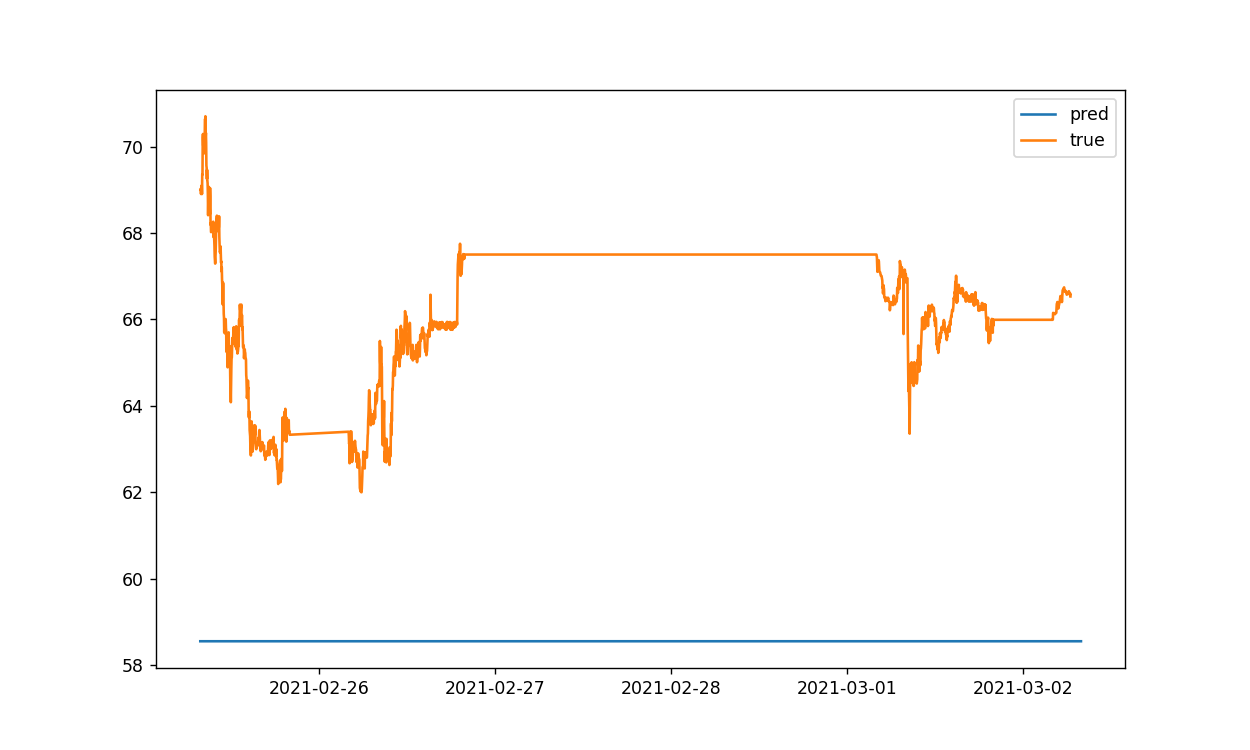

<function matplotlib.pyplot.show(block=None)>

In [82]:
%matplotlib notebook
plt.rcParams['figure.figsize'] = [10, 6]

plt.plot(test_dates_list, y_hat_descaled['adj_close'])
plt.plot(test_dates_list, test_close_vals)
plt.legend(['pred','true'])
plt.show

In [77]:
y_hat = clfrbf.predict(X_train)

In [78]:
train_scaled['adj_close'] = y_hat

inv_scaler = scaler.inverse_transform(train_scaled)

y_hat_descaled = pd.DataFrame(inv_scaler, columns = train_scaled.columns)

<IPython.core.display.Javascript object>


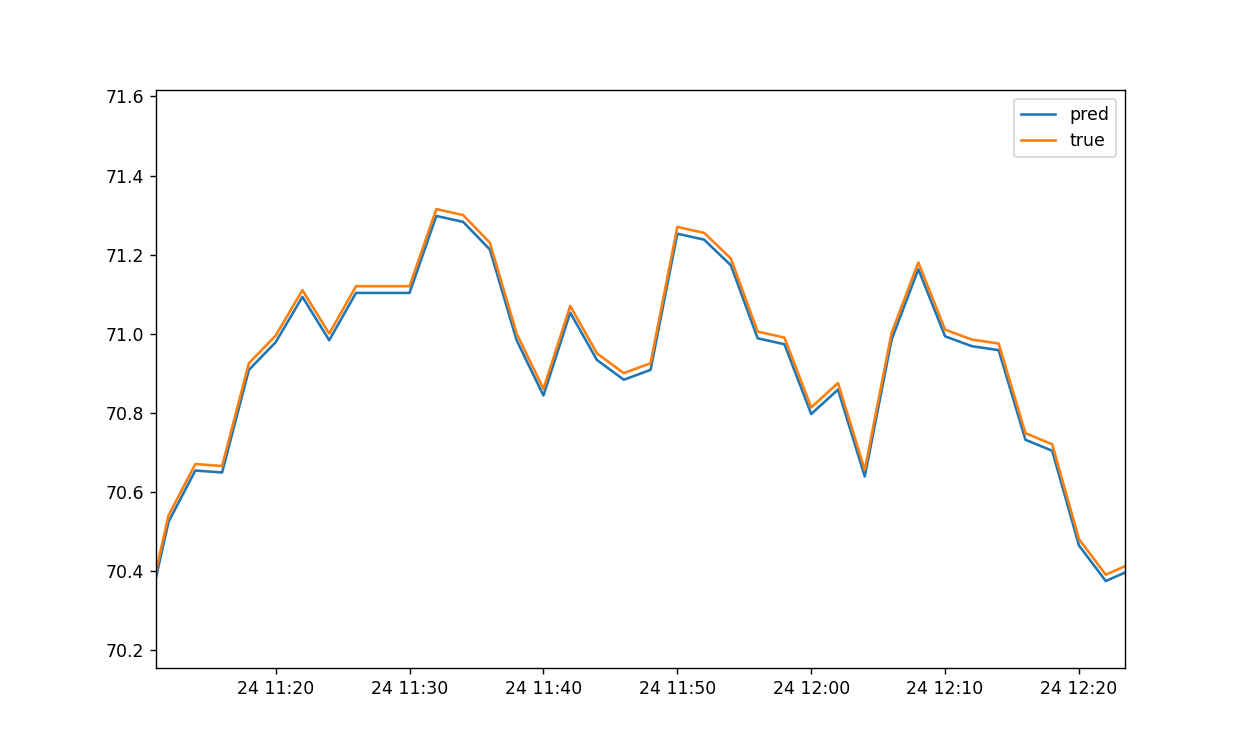

<function matplotlib.pyplot.show(block=None)>

In [79]:
%matplotlib notebook
plt.rcParams['figure.figsize'] = [10, 6]

plt.plot(train_dates_list[slow:], y_hat_descaled['adj_close'])
plt.plot(train_dates_list[slow:], train_close_vals[slow:])
plt.legend(['pred','true'])
plt.show